In [59]:
?.index

Object `.index` not found.


Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


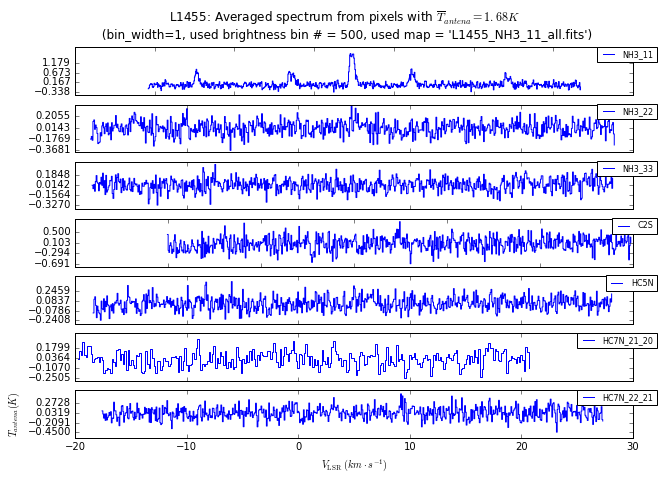

region          map          bin# ... sp_int HC7N_21_20 sp_int HC7N_22_21
------ --------------------- ---- ... ----------------- -----------------
 L1455 L1455_NH3_11_all.fits  500 ...             -0.19              2.39


In [118]:
# What are the variables we want set as default?
# Taking out the user input leaves much less comparison options? what do we want to compare actually?
# Now bin_width=500, wanted_bin=0 occure as kew words in main() and in binning() function. Is this OK?


import GAS
from spectral_cube import SpectralCube
import numpy as np
import matplotlib.pyplot as plt
import scipy.ndimage as nd
import astropy.units as u
from astropy.io import fits
from astropy.table import Table
vlsr = fits.getdata('L1455_eVlsr_v1.fits')
%pylab
%matplotlib inline


files =['L1455_NH3_11_all.fits', 'L1455_NH3_22_all.fits', 'L1455_NH3_33_all.fits',
       'L1455_C2S_all.fits', 'L1455_HC5N_all.fits', 'L1455_HC7N_21_20_all.fits',
       'L1455_HC7N_22_21_all.fits']
bin_width = 500
thisbin = 1
map_name = 'L1455_NH3_11_all.fits'
table_row = [[files[1][0:5], map_name, thisbin, bin_width]]
table_names = ['region', 'map', 'bin#', 'bin width']


def main(bin_width, thisbin):   
    # This is the main routine.
    loop_count = 0
    fig = plt.figure(figsize=(10,7))
    # for plotting plots in a single figure put plt.figure before all the .plot commands
    # otherwise you will get the plots in a different figures
    
    ax1 = plt.subplot(len(files), 1, 1)
    
    y, x, med = binning(map_name, bin_width, thisbin)
    # This takes in a 2D map and returns a 2D map where the image values are the bin to which a pixel belongs.
    
    for file_name in files:            
        sp_av, cube = averaging(file_name, y, x)
        thiscube_spectrum_dv, cube, offset_velocity = averaging_over_dopplervel(file_name, y, x)
        #Change to velocity axis and such here as well.  Then average all spectra with that bin label.
        ax = fig.add_subplot(len(files),1,loop_count+1)
        plt.plot(offset_velocity,thiscube_spectrum_dv, drawstyle='steps')
        plt.yticks(np.arange(min(thiscube_spectrum_dv), max(thiscube_spectrum_dv), (max(thiscube_spectrum_dv)-min(thiscube_spectrum_dv))/4))     
    
        
        if file_name != files[-1]:
            plt.setp(ax.get_xticklabels(), visible=False)

#         file_name.strip([0:7]).strip([-1:-4])
        file_name = file_name[6:-9]
        plt.legend([file_name], bbox_to_anchor=(1.05, 1.1), prop={'size':8})
        
        loop_count += 1        

#     plt.legend(leg, loc = 5, prop={'size':8})
#     ax.legend(bbox_to_anchor=(1.05, 0), loc='lower left', borderaxespad=0.)
#     fig.legend(curves_names, leg, bbox_to_anchor=(0.5, -0.15))
#     figtext(.1,.0,'averaging over brightness, with doppler v correction, thisbin=2' , fontsize=8)
#     fig.suptitle("averaging over brightness with brightnes bin = %r for bin width = %r" %(thisbin, bin_width), fontsize=12)
    fig.suptitle("L1455: Averaged spectrum from pixels with $\overline{T}_{antena} = %rK$ \n (bin_width=%r, used brightness bin # = %r, used map = %r)"
                 %(med, bin_width, thisbin, map_name), fontsize=12)
    plt.ylabel(r'$T_{antena} (K)$')
    plt.xlabel(r'$V_{\mathrm{LSR}}\ (km \cdot s^{-1})$')
#     plt.savefig("L1455:BinsAveraging_TemperatureMap_bin_width=%r thisbin%r.png" %(bin_width, thisbin))
    plt.show()
    make_table(files, map_name, thisbin, bin_width, y, x)
    
def binning(f_nam, bin_width, thisbin):
    """A function creating brightness bins of pixels, and eventualy a map, in the given spectral cube"""
    cube = SpectralCube.read(f_nam)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    Tmax = cube.apply_numpy_function(np.nanmax,axis=0) # array of the maximum values in the spectra of each pixel
    baddata = nd.morphology.binary_dilation(np.isnan(Tmax),np.ones((25,25)))
    Tmax[baddata]=0.0
    Tmax[np.isfinite(Tmax)]
    
    bin_arr = np.sort(Tmax[np.isfinite(Tmax)])
    bin_arr2 = bin_arr[:: - bin_width] # this creates an array of the bin margins, in which every bin has a width of "bin_width"  
    bins = np.digitize(Tmax,bin_arr2)
    y, x = np.where(bins==thisbin)
    med = round(np.median(Tmax[y,x]), 2)
    return y, x, med

def averaging(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    return sp_av, cube

def averaging_over_dopplervel(file_name, y, x):
    cube = SpectralCube.read(file_name)
    cube = cube.with_spectral_unit(u.km/u.s,velocity_convention='radio')
    sp_av = np.nanmean(cube.filled_data[:,y,x].value,axis=1)
    thiscube_spectrum_dv, offset_velocity = GAS.gasBinning.BinByMask(cube, CentroidMap = vlsr, x = x, y = y)
    return thiscube_spectrum_dv, cube, offset_velocity

def spectral_integral(offset_velocity, thiscube_spectrum_dv):
    tracking = []
    for i in range(len(offset_velocity)):
        if -2<= offset_velocity[i] <= 2:
            tracking.append(i)   # saves all the indeces of the offset_velocity-array, where -2<=offset_velocity[i]<=2
    
    sp_integral = 0
    for i in tracking:
        sp_integral += thiscube_spectrum_dv[i] # sums all the thiscube_spectrum_dv-entries, where the offset is -2<=offset_velocity[i]<=2
    sp_integral = round(sp_integral, 2)
    return sp_integral

    
def make_table(files, map_name, thisbin, bin_width, y, x):
    table_row = [[files[1][0:5], map_name, thisbin, bin_width]]
    table_names = ['region', 'map', 'bin#', 'bin width']
    for file_name in files:
        thiscube_spectrum_dv, cube, offset_velocity= averaging_over_dopplervel(file_name, y, x)
        sp_integral = spectral_integral(offset_velocity, thiscube_spectrum_dv)
        table_row[0].append(sp_integral)
        table_names.append('sp_int ' + file_name[6:-9])
    print Table(rows=table_row, names=table_names, meta={'name': 'table'})


main(thisbin, bin_width)


In [93]:
?list